In [1]:
using Revise

In [5]:
using PyPlot, JuLIP, ForwardDiff, LinearAlgebra, JuLIPMaterials
Si = JuLIPMaterials.Si


function layers(at)
    dz = 1/(2*√2) * ( bulk(:Si, cubic=true) |> cell )[1,1]
    x, y, z = xyz(at)
    I0 = findall(z .<= 0.5*dz)
    I1 = findall(0.5*dz .< z .<= 1.5*dz)
    I2 = findall(1.5*dz .< z .<= 2.5*dz)
    I3 = findall(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end

sw = Si.sw_eq()
;

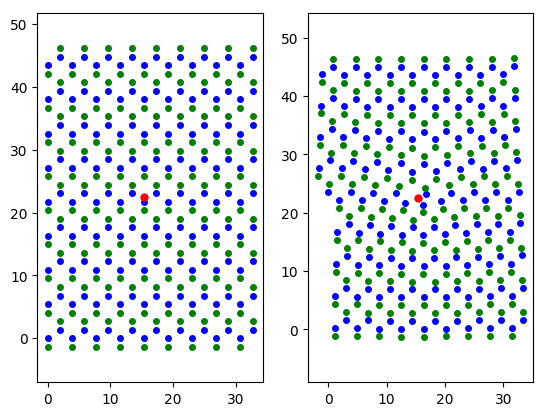

(-3.512964599727182, 35.13361519923379, -3.632362332099854, 48.82546561750301)

In [13]:
at, _, x0 = Si.si110_cluster(:Si, 9)
edge, xc = Si.edge110(:Si, 9)
figure()
subplot(1,2,1)
plot_layers(at, x0)
axis("equal")
subplot(1,2,2)
plot_layers(edge, x0)
axis("equal")

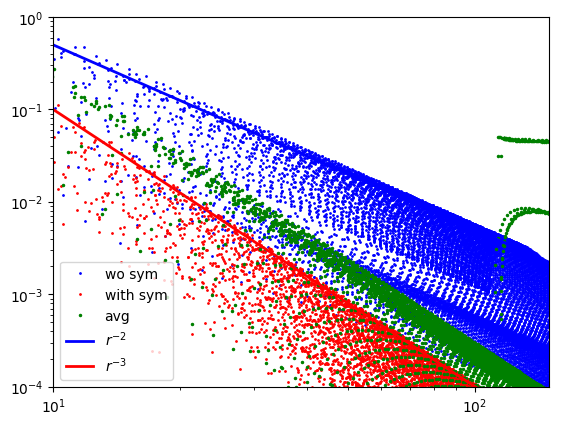

4-element Array{Float64,1}:
  10.0   
 150.0   
   0.0001
   1.0   

In [15]:
R = 61

at_nosym, xc = Si.edge110(:Si, R; calc = sw, sym=false)
r_nosym = [norm(x - xc) for x in positions(at_nosym)]
F = forces(at_nosym)
f_nosym = norm.(F)
J0, J1, Jdel = Si.si_multilattice(at_nosym; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r_nosym[J0]

at_sym, xc = Si.edge110(:Si, R; calc = sw, sym=true)
r_sym = [norm(x - xc) for x in positions(at_sym)]
f_sym = norm.(forces(at_sym))

# plotting preparation
r0 = rnn(:Si)*2
x, y, _ = xyz(at_sym)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = findall( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )
s = [extrema(r_sym)...]
r_sym, f_sym, r_nosym, f_nosym = r_sym[Iint], f_sym[Iint], r_nosym[Iint], f_nosym[Iint]

s = [extrema(r_sym)...]
loglog(r_nosym, f_nosym, "b.", markersize=2, label = "wo sym")
loglog(r_sym, f_sym, "r.", markersize=2, label = "with sym")
loglog(r_avg, f_avg, "g.", markersize=3, label = "avg")
loglog(s, 50*s.^(-2), "b-", linewidth = 2.0, label = L"r^{-2}")
loglog(s, 100*s.^(-3), "r-", linewidth = 2.0, label = L"r^{-3}")
legend(loc="lower left")
axis([10, 150, 1e-4, 1.0])

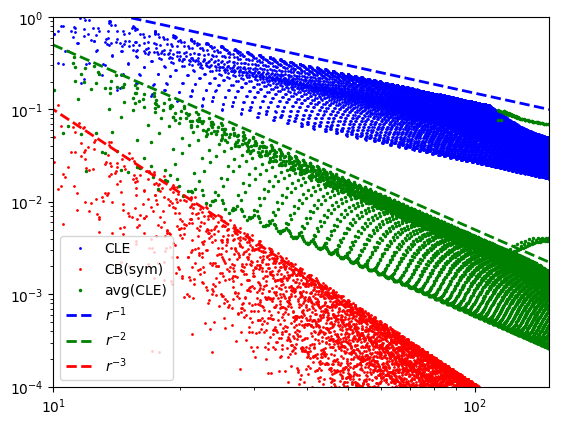

4-element Array{Float64,1}:
  10.0   
 150.0   
   0.0001
   1.0   

In [17]:
R = 61

at_nosym, xc = Si.edge110(:Si, R; calc = sw, sym=nothing)
r_nosym = [norm(x - xc) for x in positions(at_nosym)]
F = forces(at_nosym)
f_nosym = norm.(F)
J0, J1, Jdel = Si.si_multilattice(at_nosym; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r_nosym[J0]

at_sym, xc = Si.edge110(:Si, R; calc = sw, sym=true)
r_sym = [norm(x - xc) for x in positions(at_sym)]
f_sym = norm.(forces(at_sym))

# plotting preparation
r0 = rnn(:Si)*2
x, y, _ = xyz(at_sym)
xL, xR = extrema(x); yL, yR = extrema(y)
Iint = findall( (xL+2*r0 .< x .< xR - 2*r0) .* (yL+2*r0 .< y .< yR - 2*r0) )
s = [extrema(r_sym)...]
r_sym, f_sym, r_nosym, f_nosym = r_sym[Iint], f_sym[Iint], r_nosym[Iint], f_nosym[Iint]

s = [extrema(r_sym)...]
loglog(r_nosym, f_nosym, "b.", markersize=2, label = "CLE")
loglog(r_sym, f_sym, "r.", markersize=2, label = "CB(sym)")
loglog(r_avg, f_avg, "g.", markersize=3, label = "avg(CLE)")
loglog(s, 15*s.^(-1), "b--", linewidth = 2.0, label = L"r^{-1}")
loglog(s, 50*s.^(-2), "g--", linewidth = 2.0, label = L"r^{-2}")
loglog(s, 100*s.^(-3), "r--", linewidth = 2.0, label = L"r^{-3}")
legend(loc="lower left")
axis([10, 150, 1e-4, 1.0])

## Convergence Tests

In [18]:
include("ErrorAnalysis.jl")
ERR = ErrorAnalysis
sw = Si.sw_eq()
rbuf = 2 * cutoff(sw) + 1.0

SS = [3, 5, 8, 12, 17, 23, 30]
S_ex = 90
RR = SS * 1.1 * rnn(:Si)
R_ex = S_ex * 1.1 * rnn(:Si)
;

In [19]:
si_cell_mult(R) =
   (ceil(Int, 3 * R / cell(bulk(:Si, cubic=true))[1,1]) ÷ 2) * 2 + 1

function ref_cluster(R; kwargs...)
      L = si_cell_mult(R+rbuf)
      at, xc = Si.edge110(:Si, L; calc = sw, kwargs...)
      set_data!(at, :xc, xc)
      return at
end


ref_cluster (generic function with 1 method)

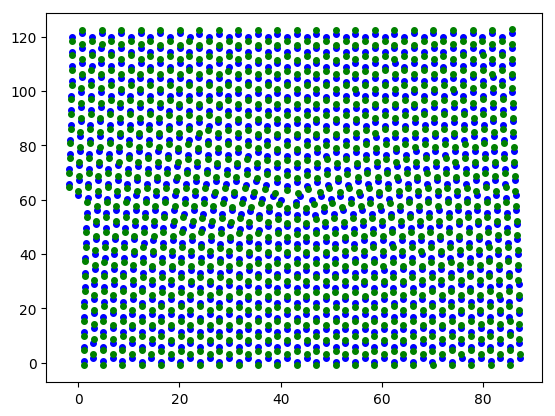

In [20]:
# check that the reference configuration looks ok
at = ref_cluster(30; sym = nothing)
plot_layers(at)

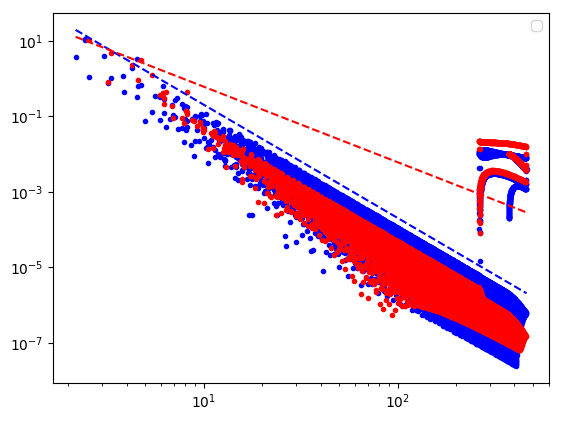

/Users/ortner/.local/lib/python2.7/site-packages/matplotlib/legend.py:932: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


PyObject <matplotlib.legend.Legend object at 0x11a5d1dd0>

In [21]:
# check that the force decay remains ok!
at_ref = ref_cluster(240; sym=true)
xc = get_data(at_ref, :xc)
F = forces(sw, at_ref)
f = norm.(F)
X = positions(at_ref)
r = [norm(x-xc) for x in X]

J0, J1, Jdel = Si.si_multilattice(at_ref; TOL=0.5)
f_avg = norm.(F[J0] .+ F[J1])
r_avg = r[J0]

loglog(r, f, "b.")
loglog(r_avg, f_avg, "r.")
s = [extrema(r)...]
loglog(s, 200* s.^(-3), "b--", s, 60*s.^(-2), "r--")
legend("f", "f_avg")

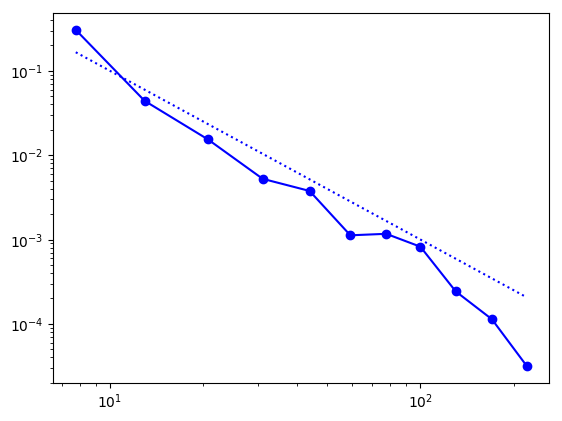

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11a601b90>
 PyObject <matplotlib.lines.Line2D object at 0x13a44b890>

In [23]:
netFs = Float64[]
RR2 = [RR; [100, 130, 170, 220]]
for R in RR2
    IR = findall(r .< R)
    Fnet = sum(F[IR])
#     @show Fnet
    push!(netFs, norm(Fnet))
end 
loglog(RR2, netFs, "bo-", RR2, 10*RR2.^(-2), "b:")

In [36]:
function setup_edge(R, at_ref; verbose=false)
   X0 = positions(at_ref)
   xc = get_data(at_ref, :xc)
   r = [norm(x[1:2]-xc[1:2]) for x in X0]
   IR = findall(r .<= R+rbuf)
   at = Atoms(:Si, X0[IR])
   set_cell!(at, cell(at_ref))
   fixedcell!(at)
   set_clamp!(at, findall(r[IR] .>= R))
   set_calculator!(at, sw)
   set_pbc!(at, (false, false, true))
   set_data!(at, :IR, IR)
   set_data!(at, :X0, X0[IR])
   set_data!(at, :xc, xc)
   return at 
end



function solve_edge(R, at_ref; verbose=false)
   at = setup_edge(R, at_ref; verbose=verbose)
   P = JuLIP.Preconditioners.FF(at, sw)
   minimise!(at; verbose=verbose, gtol = 1e-8, precond=P)
   g = gradient(at)
   verbose && @show norm(g, Inf)
   verbose && println("Take one Newton step")
   H = hessian(at)
   x = dofs(at)
   x -= H \ g 
   set_dofs!(at, x)
   g = gradient(at)
   verbose && @show norm(g, Inf)
   return at
end

solve_edge (generic function with 1 method)

In [37]:
# test that the comparison solution has all the "right" properties

In [38]:
at_ref = ref_cluster(R_ex; sym = true)
at_ex = solve_edge(R_ex, at_ref; verbose=true)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [229.43635874072962,133.56261915460524, ...]
 * Minimizer: [229.4363546318609,133.56256662246545, ...]
 * Minimum: -1.513969e+05
 * Iterations: 25
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.93e-11 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 8.13e-05 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 55
 * Gradient Calls: 26
norm(g, Inf) = 8.125144811460696e-5
Take one Newton step
norm(g, Inf) = 3.829634220853251e-9


Atoms{Float64}(StaticArrays.SArray{Tuple{3},Float64,1,3}[[210.253, 128.148, 1.91979], [214.09, 128.145, 1.91979], [217.926, 128.143, 1.91979], [217.926, 126.787, 7.8503e-17], [221.763, 128.14, 1.91979], [221.763, 126.784, 2.35516e-16], [225.599, 128.138, 1.91979], [225.599, 126.782, 3.14019e-16], [227.517, 125.424, 7.8503e-17], [229.436, 128.137, 1.91979]  …  [279.346, 601.902, 1.91979], [281.267, 604.619, 7.8503e-17], [283.189, 603.262, 3.92522e-16], [283.189, 601.903, 1.91979], [287.032, 603.264, 3.14019e-16], [287.031, 601.905, 1.91979], [290.874, 603.266, 1.57006e-16], [290.874, 601.907, 1.91979], [294.717, 601.909, 1.91979], [298.559, 601.911, 1.91979]], StaticArrays.SArray{Tuple{3},Float64,1,3}[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]

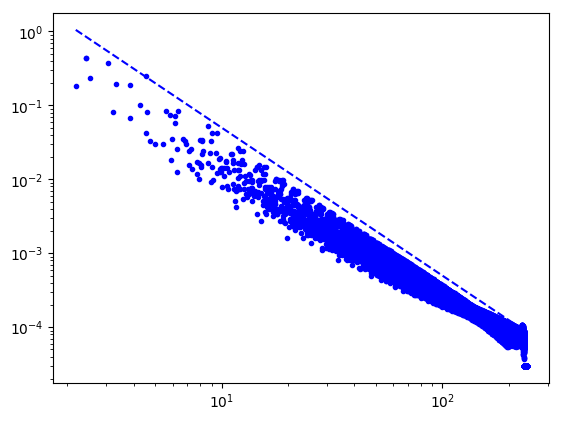

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13a465890>

In [41]:
# decay of strain 
X0 = get_data(at_ex, :X0)
xc = get_data(at_ex, :xc)
u = norm.(positions(at_ex) - X0)
e = JuLIPMaterials.strains(positions(at_ex) - X0, at_ex; rcut = 1.5 * rnn(:Si))
r = [norm(x - xc) for x in X0]
s = [extrema(r)...]
loglog(r, e .+ 3e-5, "b.")
# loglog(r, u + 1e-3, "r.")
loglog(s, 5*s.^(-2), "b--")
# loglog(s, s.^(-1), "r--")

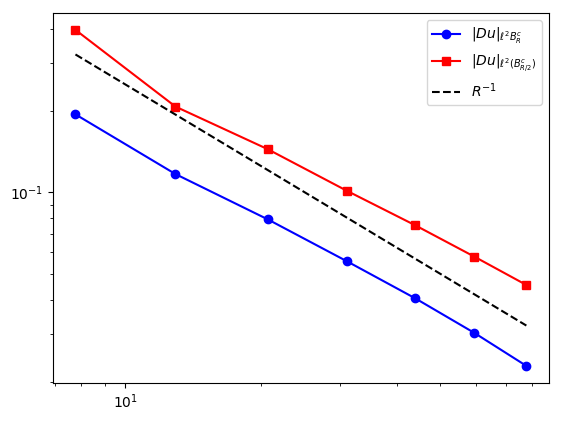

PyObject <matplotlib.legend.Legend object at 0x11cc52b90>

In [43]:
# decay of exterior norm
outer_nrm = Float64[]
outer_nrm2 = Float64[]
for R in RR
    Iout = findall(r .> R)
    push!(outer_nrm, norm(e[Iout]))
    Iout = findall(r .> R/2)
    push!(outer_nrm2, norm(e[Iout]))
end 
loglog(RR, outer_nrm, "bo-", RR, outer_nrm2, "rs-")
loglog(RR, 2.5*RR.^(-1), "k--")
legend((L"\|Du\|_{\ell^2{B_R^c}}", L"\|Du\|_{\ell^2(B_{R/2}^c)}", L"R^{-1}"))

# Actual Convergence of Solution

In [44]:
# Base.error(at::Atoms, at_ex::Atoms) =
#       ERR.error_energynorm(positions(at),    get_data(at,    :X0),
#                            positions(at_ex), get_data(at_ex, :X0), rnn(:Si))

function error2(at::Atoms, at_ex::Atoms, at_ref, p=2)
    U = positions(at) - get_data(at, :X0)
    IR = get_data(at, :IR)

    U_ex = positions(at_ex) - get_data(at_ex, :X0)
    IR_ex = get_data(at_ex, :IR)
    
    U_err = zeros(JVecF, length(at_ref))
    U_err[IR_ex] += U_ex
    U_err[IR] -= U
    dU_err = JuLIPMaterials.strains(U_err, at_ref; rcut = 1.5 * rnn(:Si))
    return norm(dU_err, p)
end 

error2 (generic function with 2 methods)

In [45]:
# at_ref = ref_cluster(R_ex; sym = true)
# at_ex = solve_edge(R_ex, at_ref)
at_nref = ref_cluster(R_ex; sym = false)
at_nex = solve_edge(R_ex, at_nref)
at_xref = ref_cluster(R_ex; sym = nothing)
at_xex = solve_edge(R_ex, at_xref)
;

In [48]:
err_sym = Float64[]
errinf_sym = Float64[]
# N_sym = Int[]
err_nsym = Float64[]
errinf_nsym = Float64[]
# N_nsym = Int[]
err_xsym = Float64[]
errinf_xsym = Float64[]
# N_xsym = Int[]

for (iR, R) in enumerate(RR)
    @show iR
   # sym = true
   at = solve_edge(R, at_ref)
   @show err = error2(at, at_ex, at_ref)
#    push!(N_sym, length(at.cons.ifree) ÷ 3)
   push!(err_sym, err)
   push!(errinf_sym, error2(at, at_ex, at_ref, Inf))
    
    Xsym = positions(at)

   # sym = false
   at = solve_edge(R, at_nref)
   @show nerr = error2(at, at_nex, at_ref)
#    push!(N_nsym, length(at.cons.ifree) ÷ 3)
   push!(err_nsym, nerr)
   push!(errinf_nsym, error2(at, at_nex, at_ref, Inf))

    Xcb = positions(at)
#     @show maximum(norm.(Xsym - Xcb))

   # sym = nothing
   at = solve_edge(R, at_xref)
   @show xerr = error2(at, at_xex, at_ref)
#    push!(N_xsym, length(at.cons.ifree) ÷ 3)
   push!(err_xsym, xerr)
   push!(errinf_xsym, error2(at, at_xex, at_ref, Inf))
end

iR = 1
err = error2(at, at_ex, at_ref) = 0.2448675006230309
nerr = error2(at, at_nex, at_ref) = 0.23896647942122237
xerr = error2(at, at_xex, at_ref) = 0.4962639646371751
iR = 2
err = error2(at, at_ex, at_ref) = 0.1658290750271471
nerr = error2(at, at_nex, at_ref) = 0.16557891061409225
xerr = error2(at, at_xex, at_ref) = 0.4221093411448007
iR = 3
err = error2(at, at_ex, at_ref) = 0.1106193674242467
nerr = error2(at, at_nex, at_ref) = 0.10973439200812114
xerr = error2(at, at_xex, at_ref) = 0.3689189258760088
iR = 4
err = error2(at, at_ex, at_ref) = 0.07731517629199457
nerr = error2(at, at_nex, at_ref) = 0.07695648428152863
xerr = error2(at, at_xex, at_ref) = 0.3261660874876305
iR = 5
err = error2(at, at_ex, at_ref) = 0.056214975628045914
nerr = error2(at, at_nex, at_ref) = 0.05619309005745734
xerr = error2(at, at_xex, at_ref) = 0.2913331559407861
iR = 6
err = error2(at, at_ex, at_ref) = 0.04181156963773153
nerr = error2(at, at_nex, at_ref) = 0.041904465541702504
xerr = error2(at, at_xex

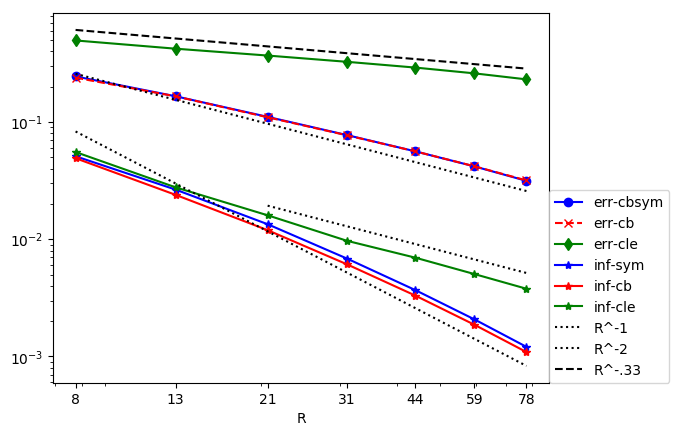

PyObject Text(0.5,24,u'R')

In [49]:
loglog(RR, err_sym, "bo-")
loglog(RR, err_nsym, "rx--")
loglog(RR, err_xsym, "gd-")
loglog(RR, errinf_sym, "b*-")
loglog(RR, errinf_nsym, "r*-")
loglog(RR, errinf_xsym, "g*-")
loglog(RR, 2*RR.^(-1), "k:")
loglog(RR, 5*RR.^(-2), "k:")
loglog(RR, 1.2*RR.^(-0.33), "k--")
loglog(RR[3:end], 0.4*RR[3:end].^(-1), "k:")
legend(("err-cbsym", "err-cb", "err-cle", "inf-sym", "inf-cb", "inf-cle", 
        "R^-1", "R^-2", "R^-.33"), loc= (1,0))
xticks(RR, string.(round.(Int, RR)))
xlabel("R")

# Try to Understand the CLE Boundary Conditions

In [20]:
R = 100
at_sym = ref_cluster(R; sym = true)
at_cb = ref_cluster(R; sym = false)
at_cle = ref_cluster(R; sym = nothing)
xc = get_data(at_sym, :xc)
r = [ norm(x - xc) for x in positions(at_sym) ]
s = [extrema(r)...]
;

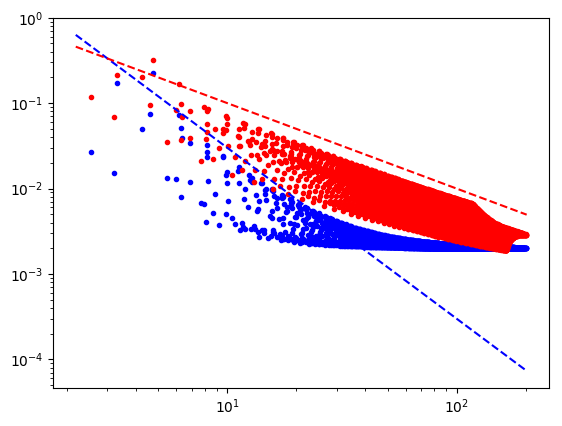

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12bec0e10>

In [21]:
J0, J1, Jdel = Si.si_multilattice(at_sym; TOL=0.5)
U = positions(at_sym) - positions(at_cb)
P = U[J0] - U[J1]
rP = r[J0]
U_cle = positions(at_cb) - positions(at_cle)
P_cle = U_cle[J0] - U_cle[J1]
loglog(rP, norm.(P) .+ 2e-3, "b.")
loglog(rP, norm.(P_cle) .+ 1e-3, "r.")
loglog(s, 3*s.^(-2), "b--")
loglog(s, 1*s.^(-1), "r--")

In [22]:
PyPlot.svg(false)

false

norm(g, Inf) = 1.2741752409132535e-6
Take one Newton step
norm(g, Inf) = 2.215228001034575e-12


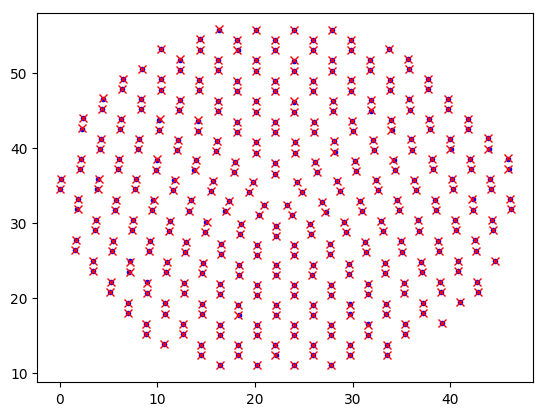

norm(g, Inf) = 9.218205068717289e-7
Take one Newton step
norm(g, Inf) = 1.6669998714746725e-12


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12b5b0a10>
 PyObject <matplotlib.lines.Line2D object at 0x12b5b0910>

In [23]:
R = 15
at_sym = solve_edge(R, ref_cluster(R; sym = true))
at_cb = solve_edge(R, ref_cluster(R; sym = false))
xs, ys, _ = xyz(at_sym)
xc, yc, _ = xyz(at_cb)
plot(xs, ys, "b.", xc, yc, "rx")